In [1]:
import os
import numpy as np

RNG = np.random.default_rng(2023)
HOME = os.getenv("HOME")

In [2]:
from dataloaders import LineReader

reader = LineReader(
    nlines=100000,
    fparams=f"{HOME}/Datasets/cell_migration/parameters.txt",
    fseries=[
        f"{HOME}/Datasets/cell_migration/dac.txt",
        f"{HOME}/Datasets/cell_migration/msd.txt"
    ]
)

In [3]:
from bayesflow.simulation import GenerativeModel, Prior, Simulator

prior = Prior(prior_fun=reader.sample_params, param_names=["ix", "A", "B", "C", "D", "E"])
simulator = Simulator(simulator_fun=reader.simulate_series)

prior_means, prior_stds = prior.estimate_means_and_stds()
model = GenerativeModel(prior, simulator, name="basic_covid_simulator")

_ = model(10)
# print(prior_means, prior_stds)

/Users/alisamar/Desktop/cell_migration/.venv/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
INFO:root:Performing 2 pilot runs with the basic_covid_simulator model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 6)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 2, 79)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


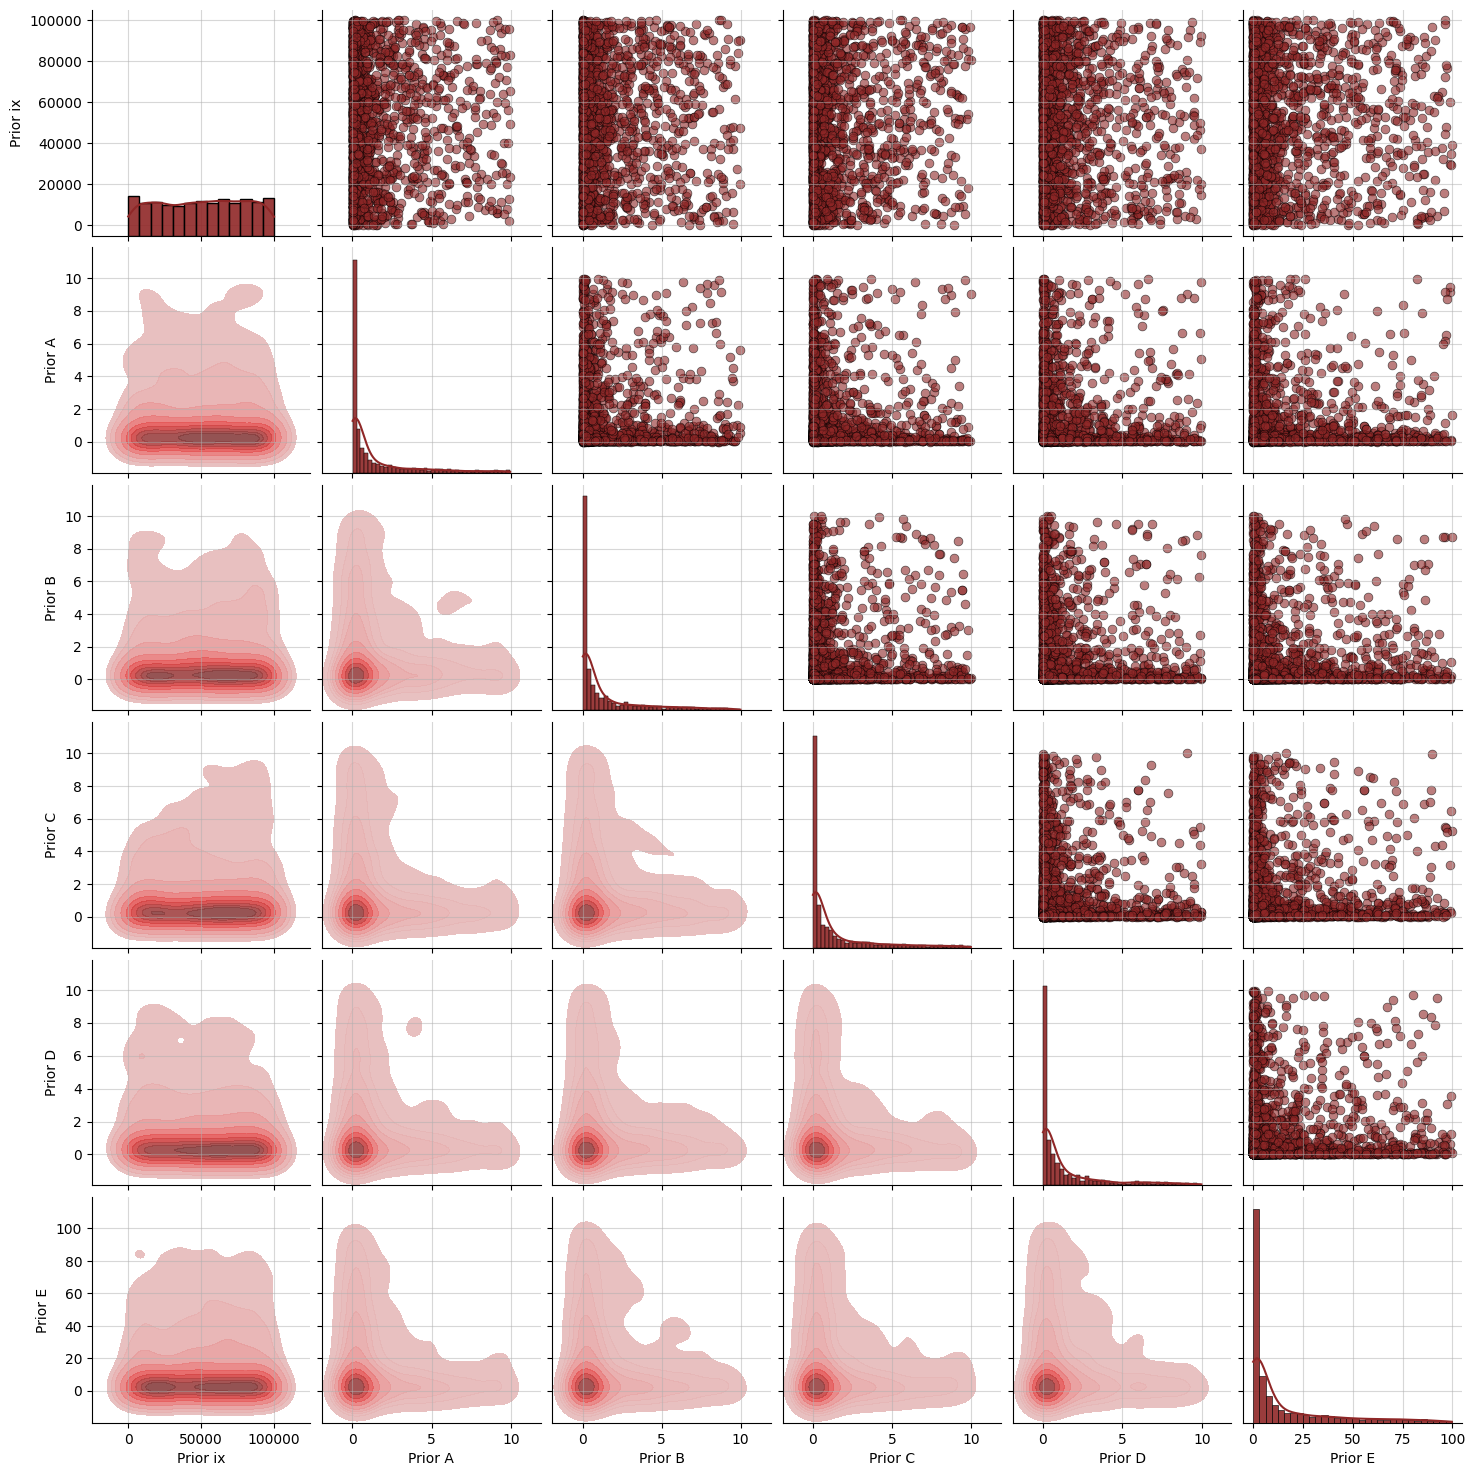

In [4]:
# As per default, the plot_prior2d function will obtain 1000 draws from the joint prior.
f = prior.plot_prior2d()

In [5]:
from bayesflow.networks import InvertibleNetwork, SequenceNetwork
from bayesflow.amortizers import AmortizedPosterior

In [6]:
summary_net = SequenceNetwork()

In [7]:
inference_net = InvertibleNetwork(num_params=len(prior.param_names), num_coupling_layers=4)

In [8]:
amortizer = AmortizedPosterior(inference_net, summary_net, name="covid_amortizer")

In [9]:
from bayesflow.trainers import Trainer

def configure_input(forward_dict):
    """Function to configure the simulated quantities (i.e., simulator outputs)
    into a neural network-friendly (BayesFlow) format.
    """

    # Extract prior draws and z-standardize with previously computed means
    params = forward_dict["prior_draws"].astype(np.float32)
    params = (params - prior_means) / prior_stds
    
    # Convert data to logscale
    data = forward_dict["sim_data"].astype(np.float32)
    # data_mean = data.mean(axis=2)
    # data_std = data.std(axis=2)
    # print(data.shape)
    # print(data_mean.shape)
    # print(data_std)
    # data = (data - data_mean) / data_std
    # print(data)

    # Remove a batch if it contains nan, inf or -inf
    # idx_keep = np.all(np.isfinite(data), axis=(1, 2))
    # if not np.all(idx_keep):
    #     print("Invalid value encountered...removing from batch")

    return {
        "summary_conditions": data,
        "parameters": params
    }

trainer = Trainer(amortizer=amortizer, generative_model=model, configurator=configure_input, memory=True)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [10]:
amortizer.summary()

Model: "covid_amortizer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network (Invert  multiple                  299152    
 ibleNetwork)                                                    
                                                                 
 sequence_network (Sequence  multiple                  98666     
 Network)                                                        
                                                                 
Total params: 397818 (1.52 MB)
Trainable params: 397770 (1.52 MB)
Non-trainable params: 48 (192.00 Byte)
_________________________________________________________________


In [11]:
offline_data = model(len(reader.series))
history = trainer.train_offline(offline_data, epochs=30, batch_size=32, validation_sims=200)

INFO:root:Generated 200 simulations for validation.
Training epoch 1: 100%|██████████| 3125/3125 [00:27<00:00, 114.76it/s, Epoch: 1, Batch: 3125,Loss: 4.312,W.Decay: 0.153,Avg.Loss: 5.225,Avg.W.Decay: 0.156,LR: 4.99E-04]
INFO:root:Validation, Epoch: 1, Loss: 4.818
Training epoch 2: 100%|██████████| 3125/3125 [00:21<00:00, 143.73it/s, Epoch: 2, Batch: 3125,Loss: 4.992,W.Decay: 0.153,Avg.Loss: 4.903,Avg.W.Decay: 0.153,LR: 4.95E-04]
INFO:root:Validation, Epoch: 2, Loss: 4.727
Training epoch 3: 100%|██████████| 3125/3125 [00:21<00:00, 143.43it/s, Epoch: 3, Batch: 3125,Loss: 5.065,W.Decay: 0.153,Avg.Loss: 4.853,Avg.W.Decay: 0.153,LR: 4.88E-04]
INFO:root:Validation, Epoch: 3, Loss: 4.638
Training epoch 4: 100%|██████████| 3125/3125 [00:21<00:00, 142.93it/s, Epoch: 4, Batch: 3125,Loss: 5.130,W.Decay: 0.153,Avg.Loss: 4.771,Avg.W.Decay: 0.153,LR: 4.78E-04]
INFO:root:Validation, Epoch: 4, Loss: 4.500
Training epoch 5: 100%|██████████| 3125/3125 [00:22<00:00, 141.03it/s, Epoch: 5, Batch: 3125,Los

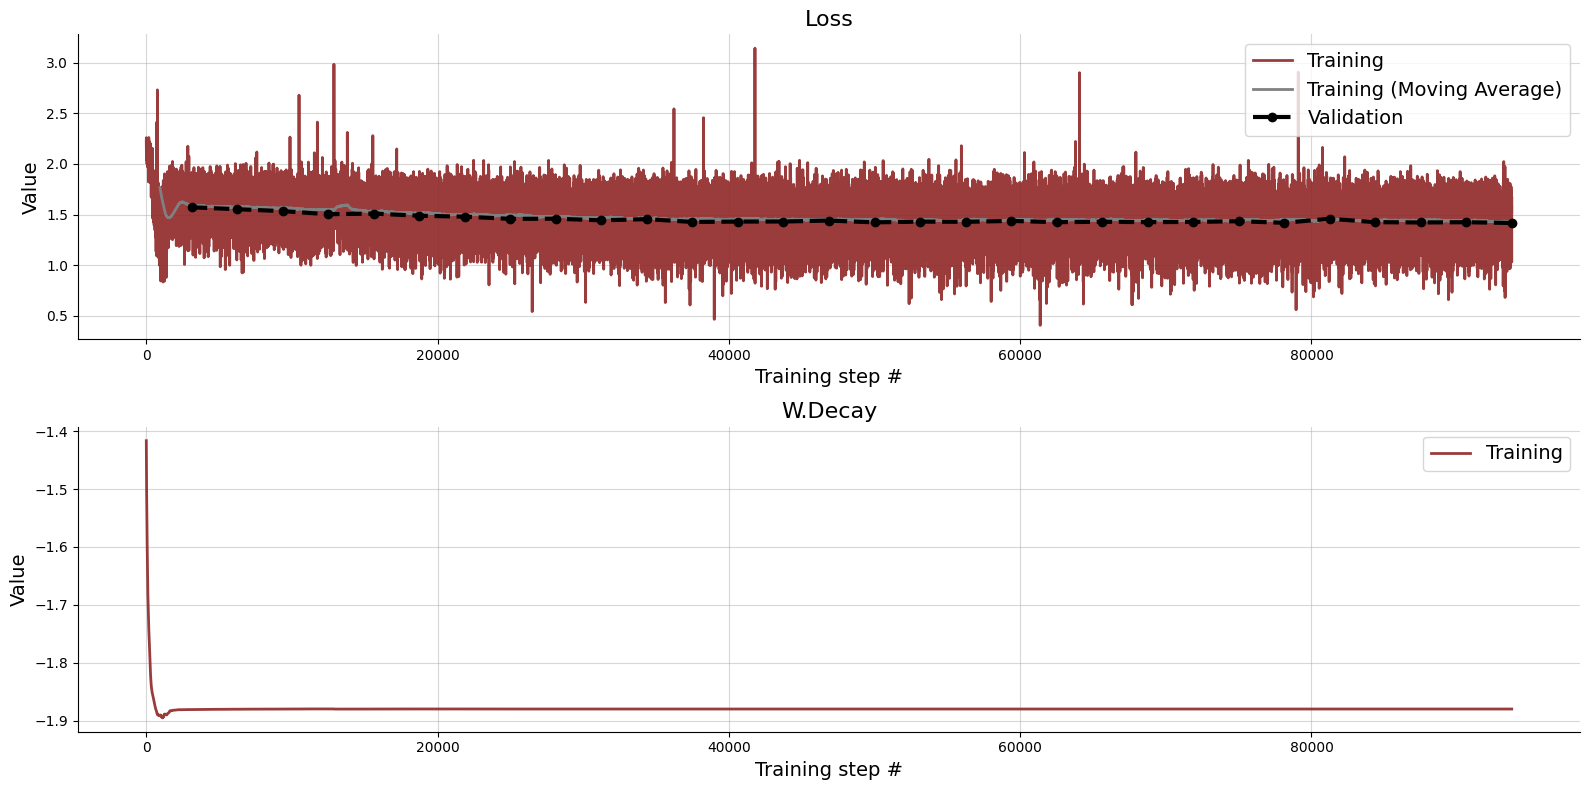

In [12]:
import bayesflow.diagnostics as diag

f = diag.plot_losses(np.log(history["train_losses"]), np.log(history["val_losses"]), moving_average=True)

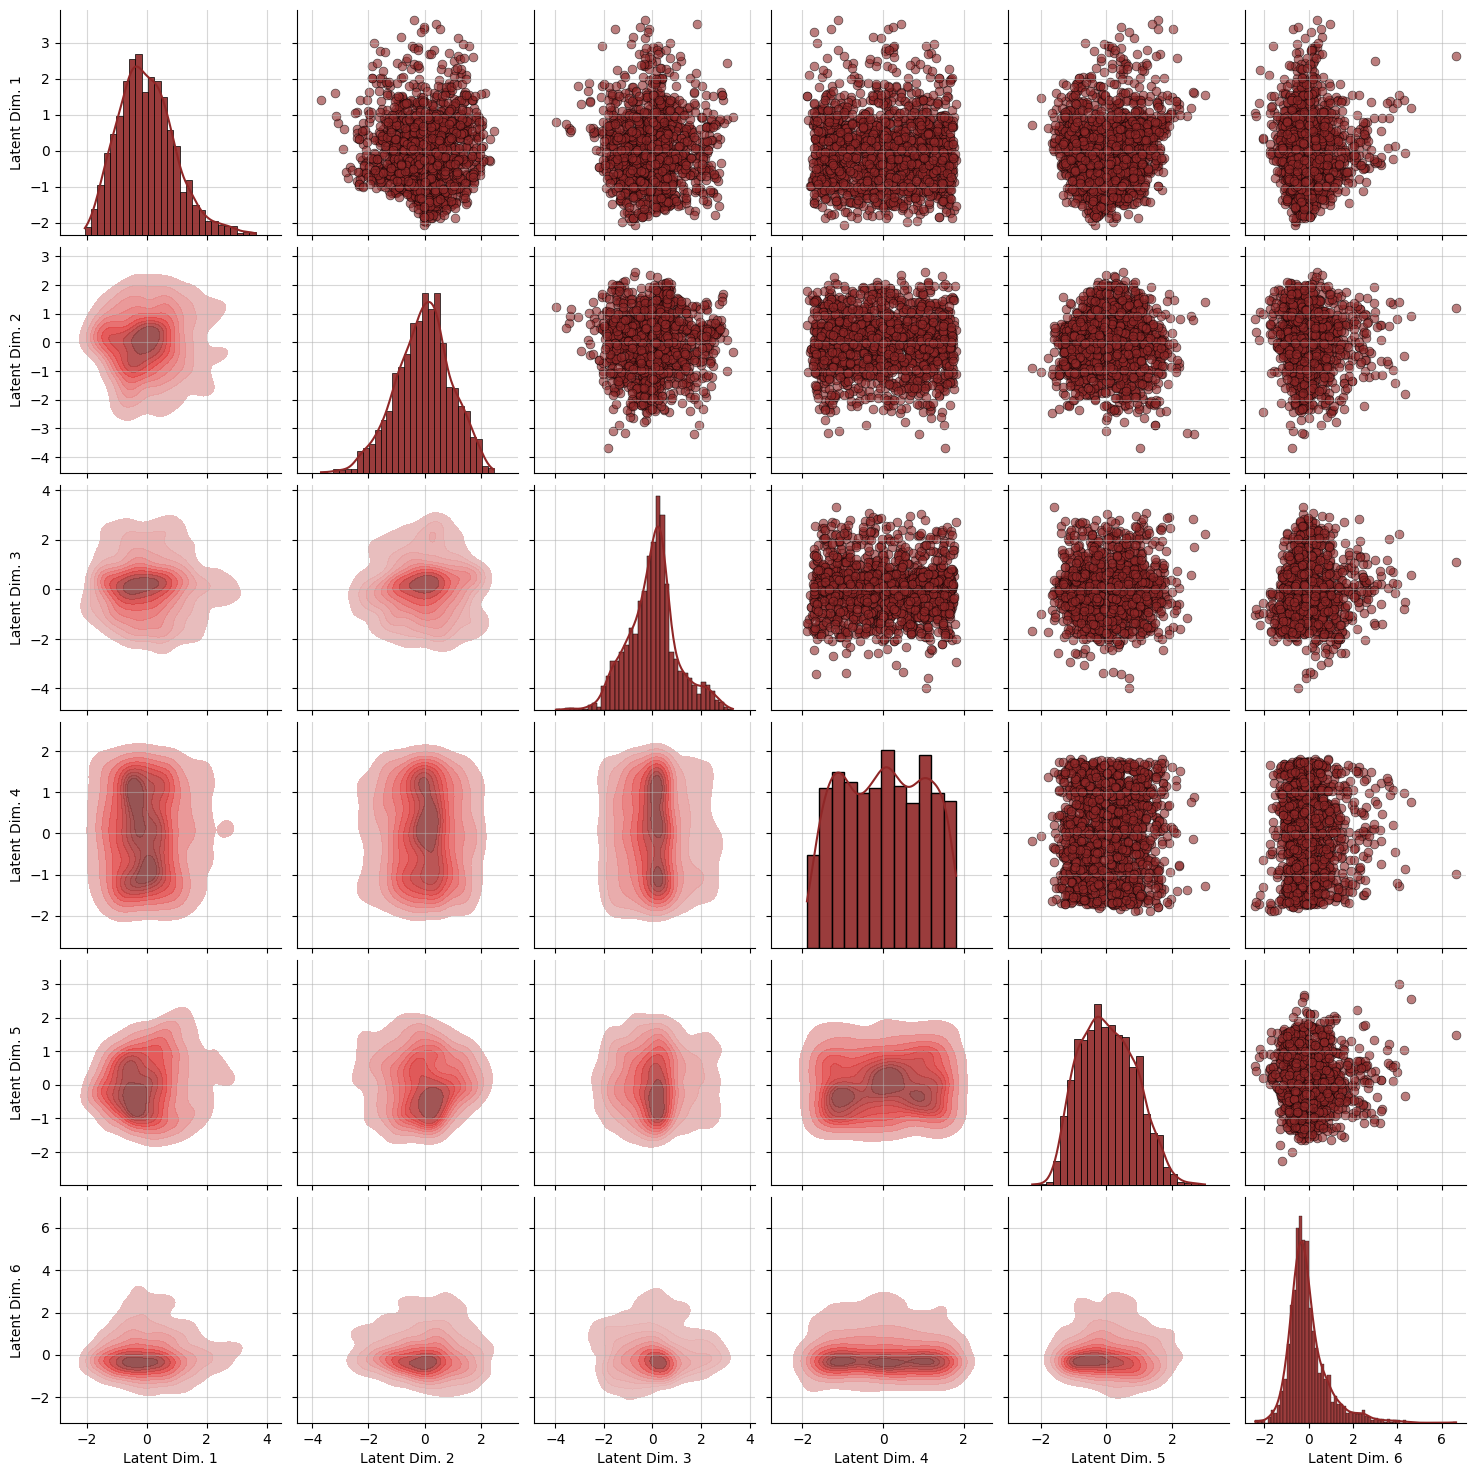

In [13]:
f = trainer.diagnose_latent2d()

In [14]:
# f = trainer.diagnose_sbc_histograms()

In [15]:
# Generate some validation data
validation_sims = trainer.configurator(model(batch_size=300))

# Generate posterior draws for all simulations
post_samples = amortizer.sample(validation_sims, n_samples=100)

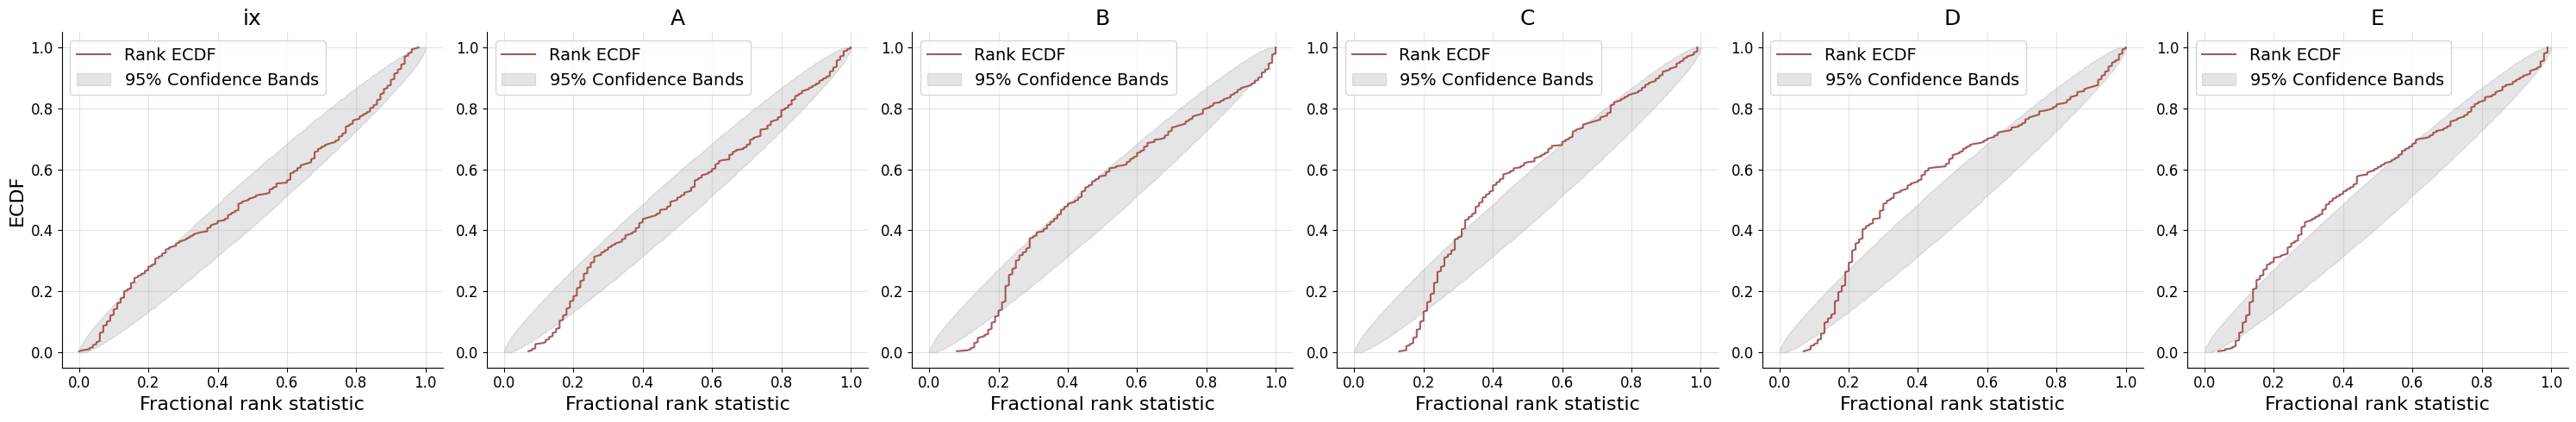

In [16]:
# Create ECDF plot
f = diag.plot_sbc_ecdf(post_samples, validation_sims["parameters"], param_names=prior.param_names)

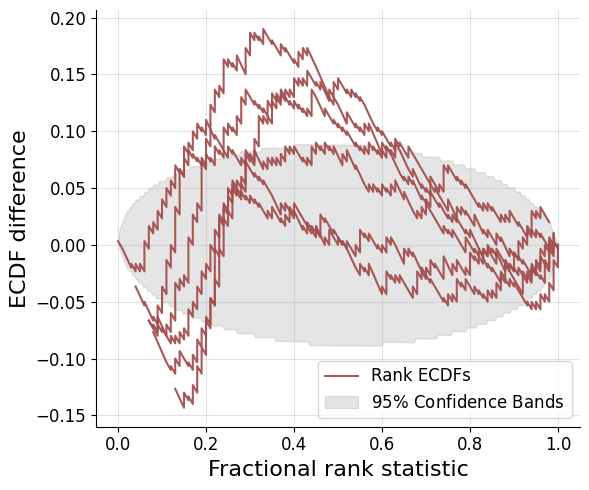

In [17]:
f = diag.plot_sbc_ecdf(
    post_samples, validation_sims["parameters"], stacked=True, difference=True, legend_fontsize=12, fig_size=(6, 5)
)

INFO:root:The ratio of simulations / posterior draws should be > 20 for reliable variance reduction, but your ratio is 3.                    Confidence intervals might be unreliable!


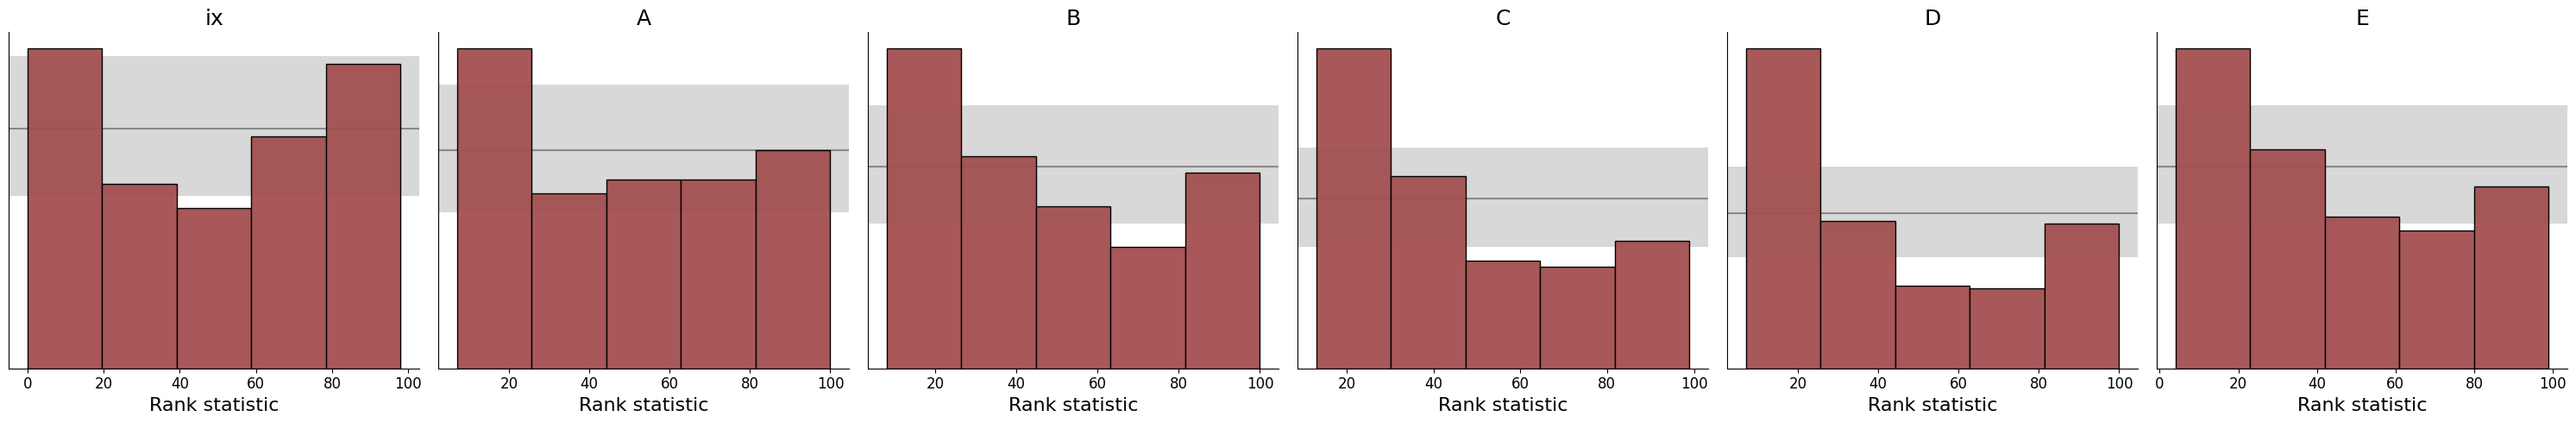

In [18]:
f = diag.plot_sbc_histograms(post_samples, validation_sims["parameters"], param_names=prior.param_names)

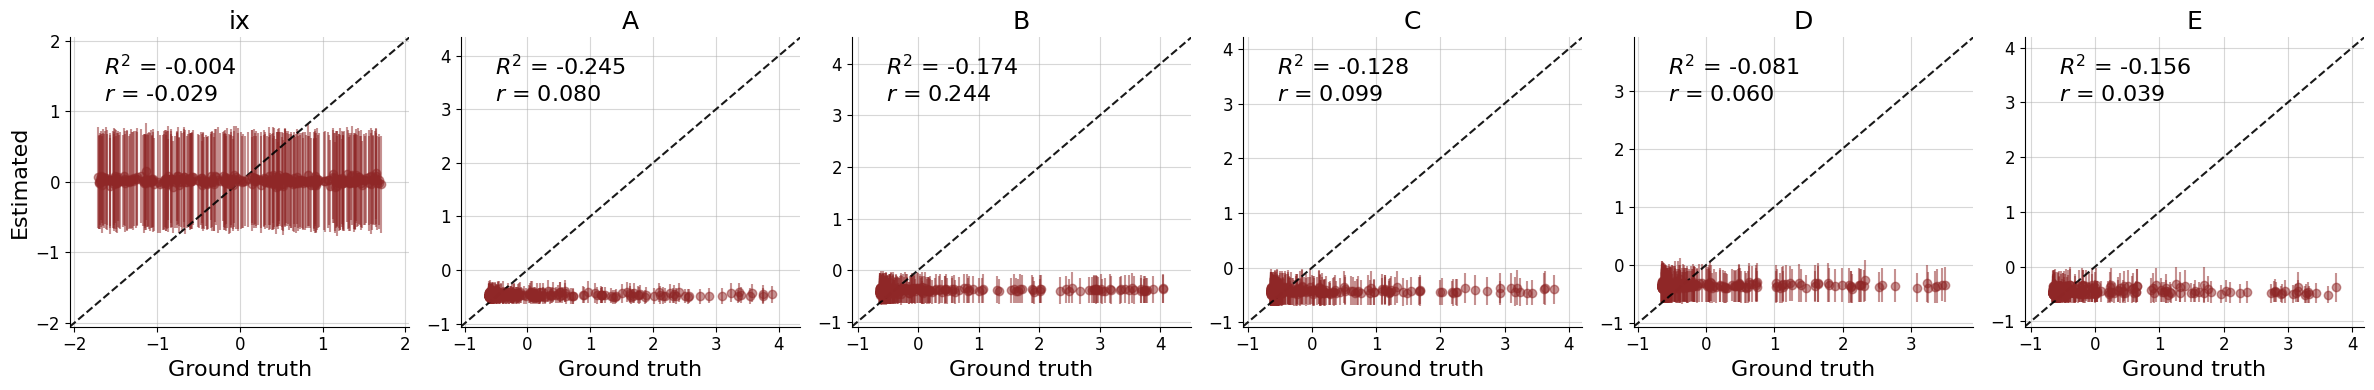

In [19]:
from diagnostics import plot_recovery

post_samples = amortizer.sample(validation_sims, n_samples=1000)
f = diag.plot_recovery(post_samples, validation_sims["parameters"], param_names=prior.param_names)

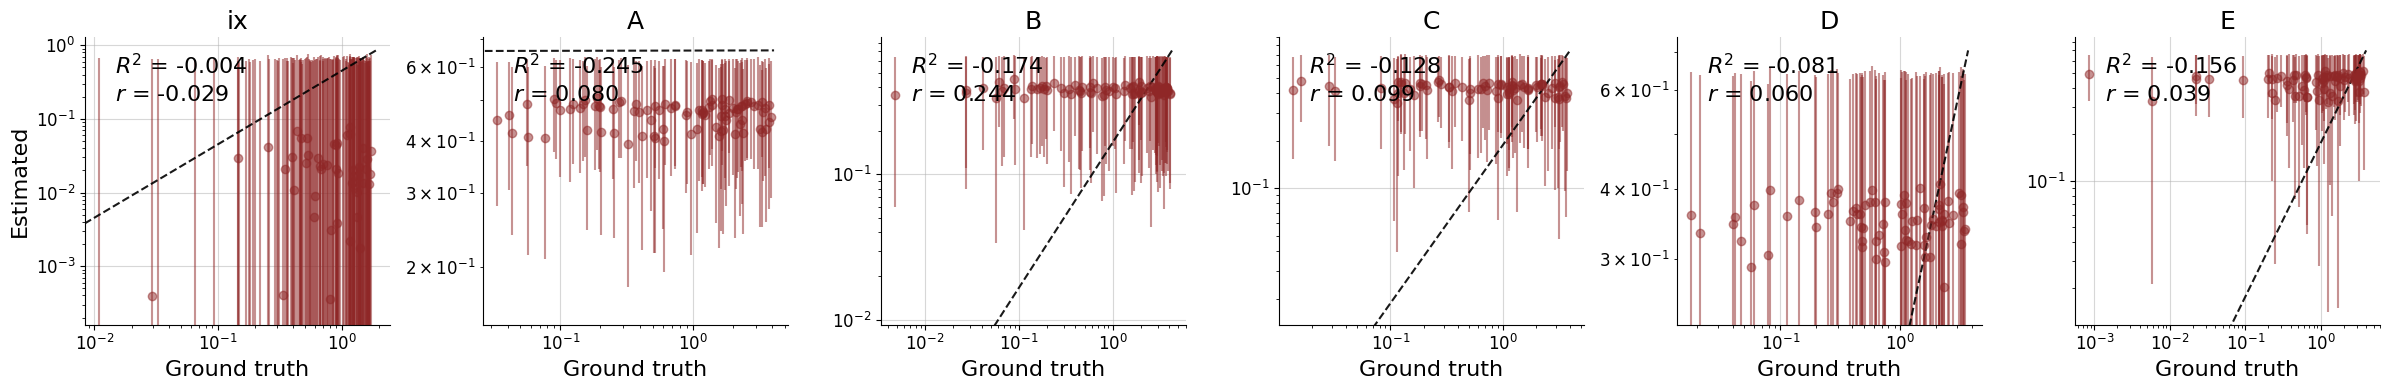

In [20]:
f = plot_recovery(post_samples, validation_sims["parameters"], param_names=prior.param_names)